In [1]:
# load images with tf.data.Dataset
# see here: https://www.tensorflow.org/tutorials/load_data/images
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE
import pathlib

df_sizes = pd.read_csv("data/data/data/sorted_metadata.csv")
path="data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
BATCH_SIZE = 32
IMG_HEIGHT = int(df_sizes.n_rows.mean()/4)
IMG_WIDTH = int(df_sizes.n_cols.mean()/4)
CLASS_NAMES = np.array(["Normal", "Pnemonia"])
test_path = f"{path}/test_modified"
data_dir = pathlib.Path(test_path)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
for f in list_ds.take(5):
    print(f.numpy())


2.0.0
b'data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test_modified/Normal/NORMAL2-IM-0131-0001.jpeg'
b'data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test_modified/Pnemonia/person146_bacteria_704.jpeg'
b'data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test_modified/Pnemonia/person1679_virus_2896.jpeg'
b'data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test_modified/Pnemonia/person62_virus_119.jpeg'
b'data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test_modified/Normal/NORMAL2-IM-0336-0001.jpeg'


In [2]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def get_onehot(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    onehot = tf.reshape(tf.one_hot(tf.where(CLASS_NAMES==parts[-2]),2), (2,))
    print(onehot.shape)
    return onehot

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=1)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
    # label = get_label(file_path)
    label = get_onehot(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [3]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

(2,)


In [4]:
def prepare_dataset(ds, cache=True, shuffle_buffer_size=1000, testing_bool=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
        # add optional shuffle - for testing, we do not want shuffling
        if not testing_bool:
            ds = ds.shuffle(buffer_size=shuffle_buffer_size)
            # Repeat forever
            ds = ds.repeat()
            ds = ds.batch(BATCH_SIZE)
        else:
            ds = ds.repeat() # two passes so we can scrape labels
            ds = ds.batch(1)
        # `prefetch` lets the dataset fetch batches in the background while the model
        # is training.
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

In [5]:
filename = 'data/test_cache'
test_ds = prepare_dataset(labeled_ds,cache=filename,testing_bool=True)

## Build ResNet model, load weights

In [27]:
model_path = "model/resnet50"
data_format = "channels_last"
inp_shape = (IMG_HEIGHT,IMG_WIDTH,1) # channels_last
input_tensor = None
resnet = tf.keras.applications.ResNet50(
    include_top=True, weights=None, input_tensor=input_tensor, input_shape=inp_shape,
    pooling=None, classes=2
)

In [28]:
num_examples = df_sizes[df_sizes.dataset_type == "TEST"].shape[0]
print(num_examples)
num_classes = CLASS_NAMES.shape[0]

# get true labels from test set
y_true = np.zeros((num_examples,num_classes))
for i, batch in zip(range(num_examples), test_ds.take(num_examples)):
    y_true[i,:] = batch[1]

624


In [30]:
y_hat_list = []
epoch_list = [10,25,50,100]
for epoch_val in epoch_list:
    model_out_base = "{}/model_H{}_W{}_unique_{:03d}epoch".format(model_path,IMG_HEIGHT,IMG_WIDTH,epoch_val)
    weights_file = "{}.h5".format(model_out_base)
    resnet.load_weights(weights_file)
    resnet.compile(optimizer='adam',
                   loss=tf.keras.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy']
                  ) 
    y_hat = resnet.predict(test_ds,steps=num_examples)
    y_hat_list.append(y_hat)

## CNN Classification Metrics

For now, we only do binary classification. The metrics we look at are:
- ROC/PR Curves
- Confusion Matrix

ResNet outputs are probabilities (softmax)

In [48]:
print(y_hat)

[[7.9214799e-01 2.0785205e-01]
 [9.9742824e-01 2.5717719e-03]
 [3.9610656e-10 1.0000000e+00]
 ...
 [1.7409869e-03 9.9825901e-01]
 [5.8053204e-13 1.0000000e+00]
 [2.7385661e-12 1.0000000e+00]]


## ROC Curve

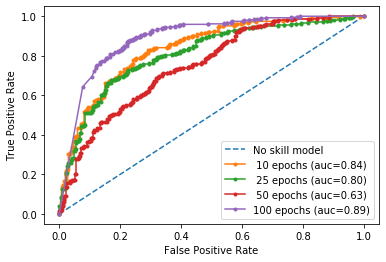

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.plot([0,1], [0,1], linestyle='--', label='No skill model')
for epochs, y_hat in zip(epoch_list, y_hat_list):
    y_probs = y_hat[:,1] # second column is "Pnemonia"
    fpr, tpr, _ = roc_curve(y_true[:,1], y_probs)
    auc = roc_auc_score(y_true, y_hat)
    plt.plot(fpr, tpr, marker='.', label='{:3} epochs (auc={:3.2f})'.format(epochs, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall Curve

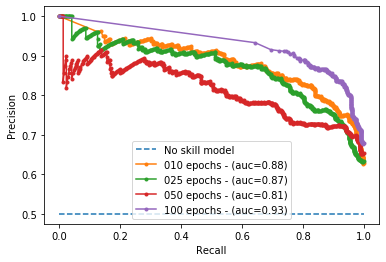

In [35]:
from sklearn.metrics import precision_recall_curve, auc, f1_score

plt.plot([0,1], [0.5,0.5], linestyle='--', label='No skill model')
for epochs, y_hat in zip(epoch_list, y_hat_list):
    y_probs = y_hat[:,1] # second column is "Pnemonia"
    precision, recall, thresholds = precision_recall_curve(y_true[:,1],y_probs)
    auc_val = auc(recall, precision)
    plt.plot(recall, precision, marker='.', label='{:03d} epochs - (auc={:3.2f})'.format(epochs, auc_val))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Confusion Matrix

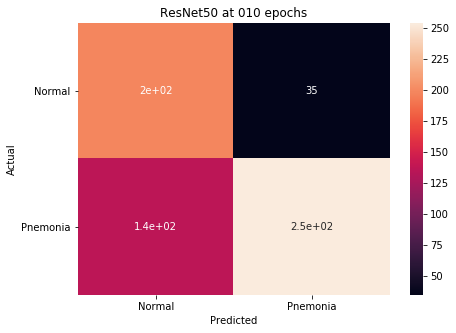

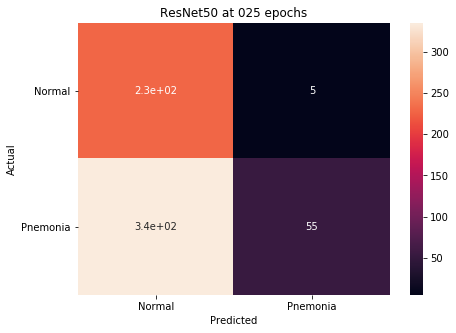

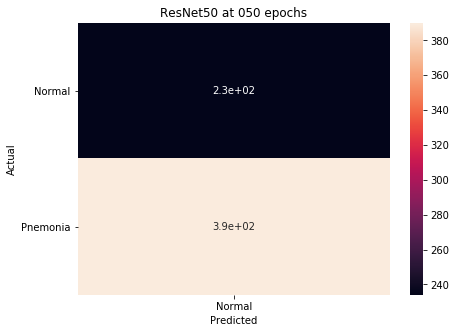

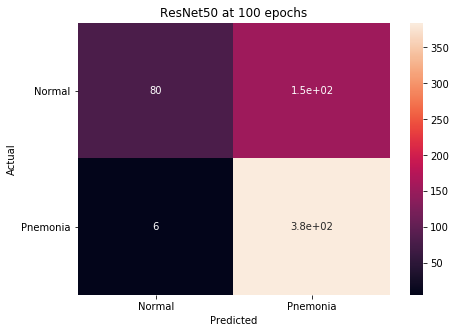

In [38]:
import pandas as pd
import seaborn as sn

for epochs, y_hat in zip(epoch_list, y_hat_list):
    # convert resnet output to onehot
    y_one_hot = np.squeeze(tf.one_hot(tf.nn.top_k(y_hat).indices, tf.shape(y_hat)[1]).numpy())
    data = {"y_test": y_true[:,1], "y_hat": y_one_hot[:,1]}
    df = pd.DataFrame(data, columns=["y_test", "y_hat"])
    confusion_matrix = pd.crosstab(df['y_test'],df['y_hat'],rownames=["Actual"],colnames=['Predicted'])
    f, ax = plt.subplots(figsize=(7,5))
    sn.heatmap(confusion_matrix, annot=True)
    ax.yaxis.set_ticklabels(CLASS_NAMES,rotation="horizontal")
    ax.xaxis.set_ticklabels(CLASS_NAMES)
    ax.set_title("ResNet50 at {:03d} epochs".format(epochs))
    plt.show()